# WHAT IS TORCH.NN *REALLY*?

这是 PyTorch 官方文档的一篇 Tutorial：[WHAT IS TORCH.NN *REALLY*?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)，深入浅出讲解了如何使用 PyTorch 构建深度学习模型。

## MNIST 数据集

MNIST 数据集是一个手写数字识别数据集，包含 60000 张训练图片和 10000 张测试图片，每张图片都是 28x28 的灰度图像。

Tutorial 使用了 `pathlib` 和 `requests` 两个库来下载和处理数据集.

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    # get the file content
    content = requests.get(URL + FILENAME).content
    # write the content to a local file
    (PATH / FILENAME).open("wb").write(content)

MNIST 数据集是以 numpy 数组的形式存储的，然后被压缩成了 gzip 格式。我们可以使用 `pickle` 库和 `gzip` 库来读取数据集。

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

每一张图都是 28x28 的矩阵，但是存的时候是被展开成了 784 维的向量。我们可以把它 reshape 回去。
并且，可以使用 `matplotlib` 库来显示图片。

torch.Size([60000, 784])


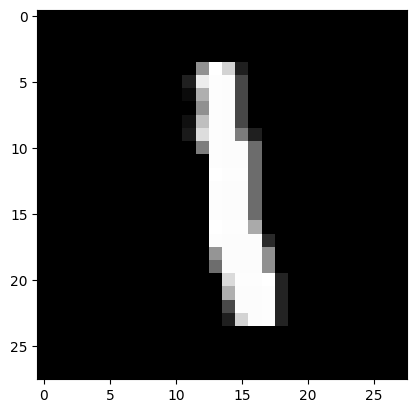

In [11]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[6].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch 使用 `torch.Tensor` 来存储数据，而不是 numpy 数组。所以我们需要把数据转换成 `torch.Tensor` 的形式。

- Tensor 是一个多维数组，它和 numpy 的 ndarray 很像，但是 Tensor 可以在 GPU 上运行，并且可以自动计算梯度。
- 可以使用 `torch.tensor` 或 `torch.as_tensor` 函数来把 numpy 数组转换成 Tensor。
    - `torch.tensor` 是一个函数，而 `torch.Tensor` 是一个类

In [3]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.as_tensor, (x_train, y_train, x_valid, y_valid)
)

或者，我们可以直接使用 `torchvision` 库来下载和处理数据集。
- `torchvision` 是一个包含了许多计算机视觉数据集的库。
- 无需转换数据格式，`torchvision` 会自动把数据转换成 `torch.Tensor` 的形式。

In [15]:
import torchvision

MNIST = torchvision.datasets.MNIST(root='data', download=True)
x_train, y_train = MNIST.data[:60000], MNIST.targets[:60000]
x_valid, y_valid = MNIST.data[60000:], MNIST.targets[60000:]
print(x_train.shape)

# 由于下面是按照 flatten 的形式来处理数据，所以需要把数据 reshape 回去
x_train, x_valid = x_train.reshape((-1, 28 * 28)), x_valid.reshape((-1, 28 * 28))
x_train, x_valid = x_train.float(), x_valid.float()
print(x_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 784])


## 从零搭建神经网络

我们先从一个简单的模型开始，然后逐步增加复杂度。

与 `numpy` 类似，Pytorch 提供了一些基本的操作，比如 `torch.randn` 来生成随机数，`torch.matmul` 来做矩阵乘法。

对于一个简单的神经网络，我们需要两个参数：
- `weigths`：初始化权重的矩阵，通常是随机的
    - 使用 [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 或者 [Kaiming](https://arxiv.org/abs/1502.01852) 初始化方法可以让模型更快收敛
- `bias`：初始化偏差的向量，通常是 0



In [5]:
import math

# Xavier 初始化方法
weights = torch.randn(784, 10) / math.sqrt(784)
# 初始化后设置 requires_grad=True，防止初始化步骤被记录
# 以 _ 结尾表示原地操作
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

由于 Tensor 支持自动计算梯度，我们可以直接使用正常的 python 方法来构建神经网络。

In [39]:
import torch.nn.functional as F

def model(xb):
    # @ 表示矩阵乘法
    return F.log_softmax(xb @ weights + bias, dim=-1)

对一个 batch 的数据进行预测，我们可以使用 `model(xb)` 来计算预测结果。

In [40]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape

(tensor([-1.1109e+02, -1.8772e+02, -2.1302e+02, -1.4413e+01, -5.8696e+01,
         -9.3142e+01, -5.9605e-07, -9.8720e+01, -1.7363e+02, -2.6312e+02],
        grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))